# 1. Training YOLO NAS

## 1.1. Prerequisites

In [2]:
# Its likely that this packages are already in the Anaconda environment
!pip install super-gradients
!pip install -q supervision
!pip install onemetric
!pip install matplotlib==3.5.2

  Using cached matplotlib-3.5.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (6.7 kB)
Using cached matplotlib-3.5.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.0
    Uninstalling matplotlib-3.9.0:
      Successfully uninstalled matplotlib-3.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
supervision 0.21.0 requires matplotlib>=3.6.0, but you have matplotlib 3.5.2 which is incompatible.


## 1.2. Name and paths of the models to be trained

In [1]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
EXPERIMENT_NAME = 'yolonas_s_custom' #Name of the new model
trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

/home/jetshu/miniconda3/envs/yolonas_train_trt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-06-26 11:22:17] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/jetshu/sg_logs/console.log
[WARNING]No module named 'pycocotools'


In [2]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

## 1.3. Dataset loading

### 1.3.1. Check path of datasets

In [12]:
import os
cwd = os.getcwd()
# Check the current file
print(f"Current file: {cwd}")
sub_dataset_dir = "dataset/flower_detection_dataset" # Insert the path of the directory of the dataset in format COCO, YOLOV5, etc.
dataset_dir = f'{cwd}/{sub_dataset_dir}'
print(f"Path of dataset file: {dataset_dir}")

Current file: /home/jetshu/Documents/github/yolo_nas_trt_training
Path of dataset file: /home/jetshu/Documents/github/yolo_nas_trt_training/dataset/flower_detection_dataset


### 1.3.2. Loading dataset

In [13]:

dataset_params = {
    'data_dir':dataset_dir,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['flower'] # Insert the classes of your dataset
}

In [14]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 30/30 [00:00<00:00, 5816.27it/s]


### 1.3.4. Data augmentation (Optional)

In [8]:
train_data.dataset.transforms

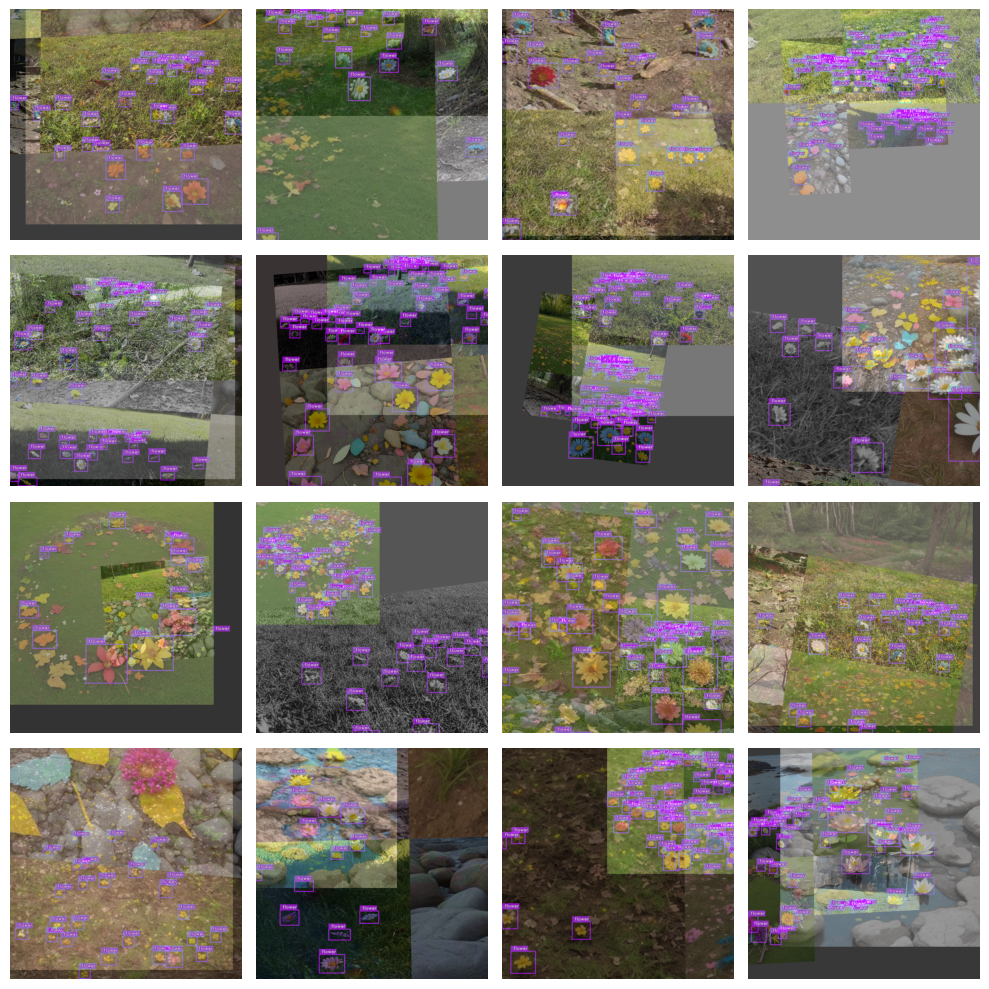

In [9]:
train_data.dataset.plot()

## 1.4. Selection of Pretrained model

In [15]:
from super_gradients.training import models
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-06-26 11:27:28] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-26 11:27:28] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-06-26 11:27:28] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


## 1.5. Hyperparamaters and training configuration

In [16]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

## 1.6. Training the model

In [17]:
import torch
torch.cuda.empty_cache()
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-06-26 11:27:41] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240626_112741_862740`
[2024-06-26 11:27:41] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolonas_s_custom/RUN_20240626_112741_862740
[2024-06-26 11:27:41] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/jetshu/miniconda3/envs/yolonas_train_trt/lib/python3.9/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/jetshu/miniconda3/envs/yolonas_train_trt/lib/python3.9/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign diff

The console stream is now moved to checkpoints/yolonas_s_custom/RUN_20240626_112741_862740/console_Jun26_11_27_41.txt


[2024-06-26 11:27:42] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            426        (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         106        (len(train_loader))
    - Gradient updates per epoch:   106        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.13K parameters), WD: 0.0001, (18.98M parameters)

[2024-06-26 11:28:36] INFO - base_sg_logger.py - Checkpoint saved i

Validating epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]
[2024-06-26 11:37:12] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


## 1.7. Visualization of the metrics and loss functions (Real Time)

### Be sure to RUN this cell before training

In [ ]:
# Execute this cell before TRAINING to see the metrics
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

# 2. Evaluation and Inference

## 2.1. Selecting trained model

In [18]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/yolonas_s_custom/RUN_20240626_112741_862740/average_model.pth") # Insert the checkpoint's path of your model

[2024-06-26 11:38:25] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/yolonas_s_custom/RUN_20240626_112741_862740/average_model.pth checkpoint.


## 2.2. Evaluating the model

### 2.2.1. Metrics of the model

In [14]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  86%|████████▌ | 6/7 [00:01<00:00,  5.90it/s]

{'PPYoloELoss/loss_cls': 2.2825086,
 'PPYoloELoss/loss_iou': 0.5325446,
 'PPYoloELoss/loss_dfl': 0.41106647,
 'PPYoloELoss/loss': 3.2261195,
 'Precision@0.50': 0.0,
 'Recall@0.50': 0.0,
 'mAP@0.50': 0.10924476385116577,
 'F1@0.50': 0.0,
 'Best_score_threshold': 0.03999999910593033}

Testing: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


### 2.2.2. Metrics and Inference of the model

In [19]:
import supervision as sv


ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_params['data_dir']}/{dataset_params['test_images_dir']}",
    annotations_directory_path=f"{dataset_params['data_dir']}/{dataset_params['test_labels_dir']}",
    data_yaml_path=f"{dataset_params['data_dir']}/data.yaml",
    force_masks=False
)

CONFIDENCE_TRESHOLD = 0.5
predictions = {}

for image_name, image in ds.images.items():
    result = best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2024-06-26 11:38:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-26 11:38:53] INFO -

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `B

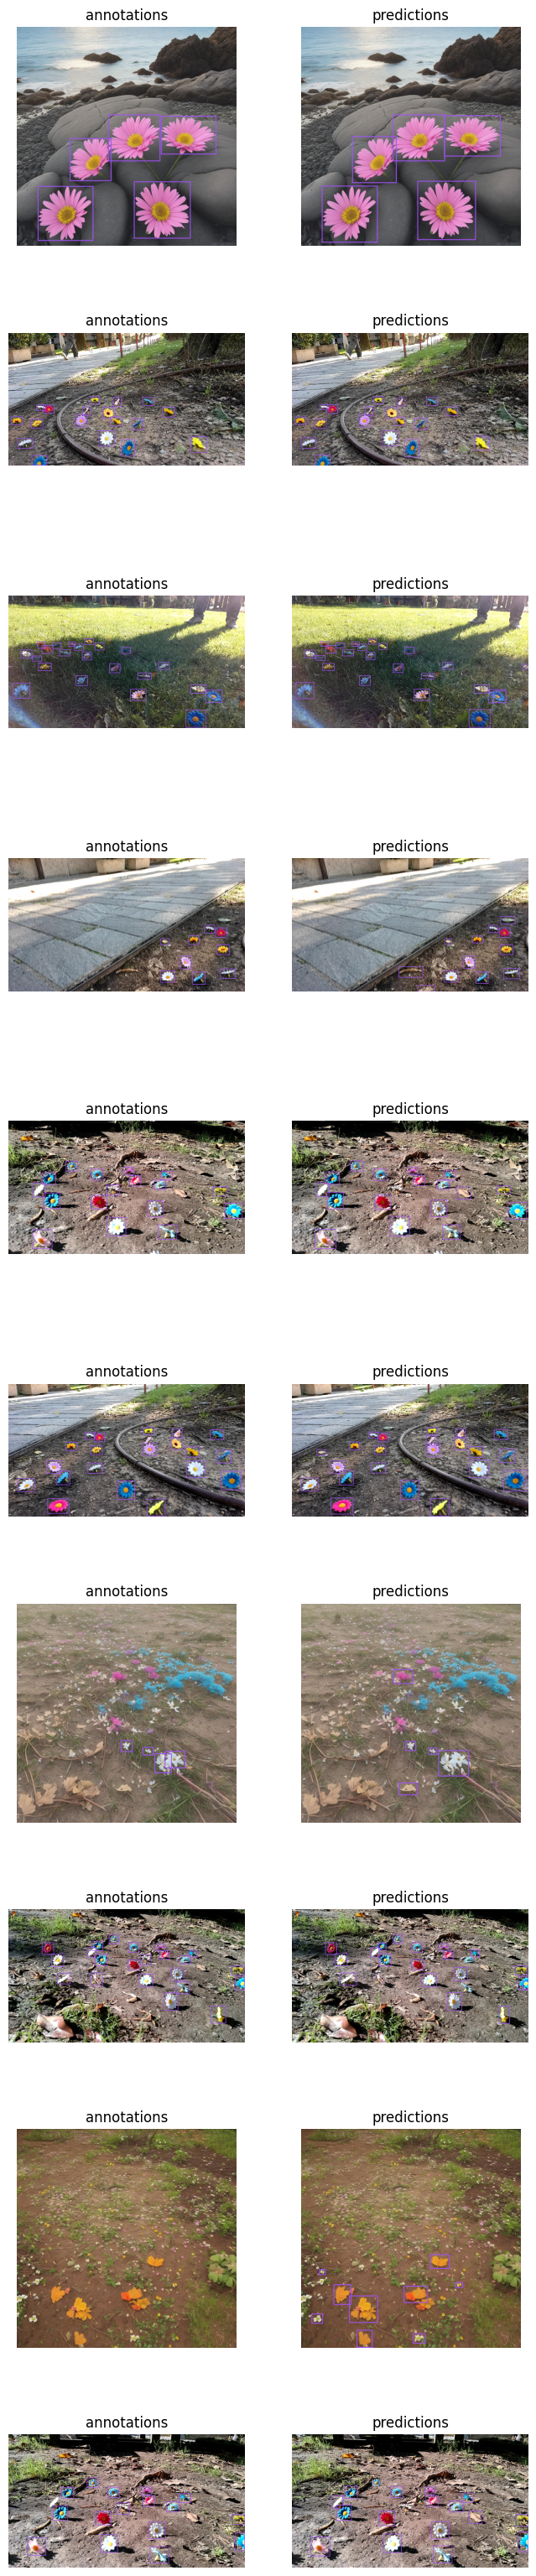

In [20]:
import random
random.seed(11)
     

import supervision as sv

MAX_IMAGE_COUNT = 10

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))
     


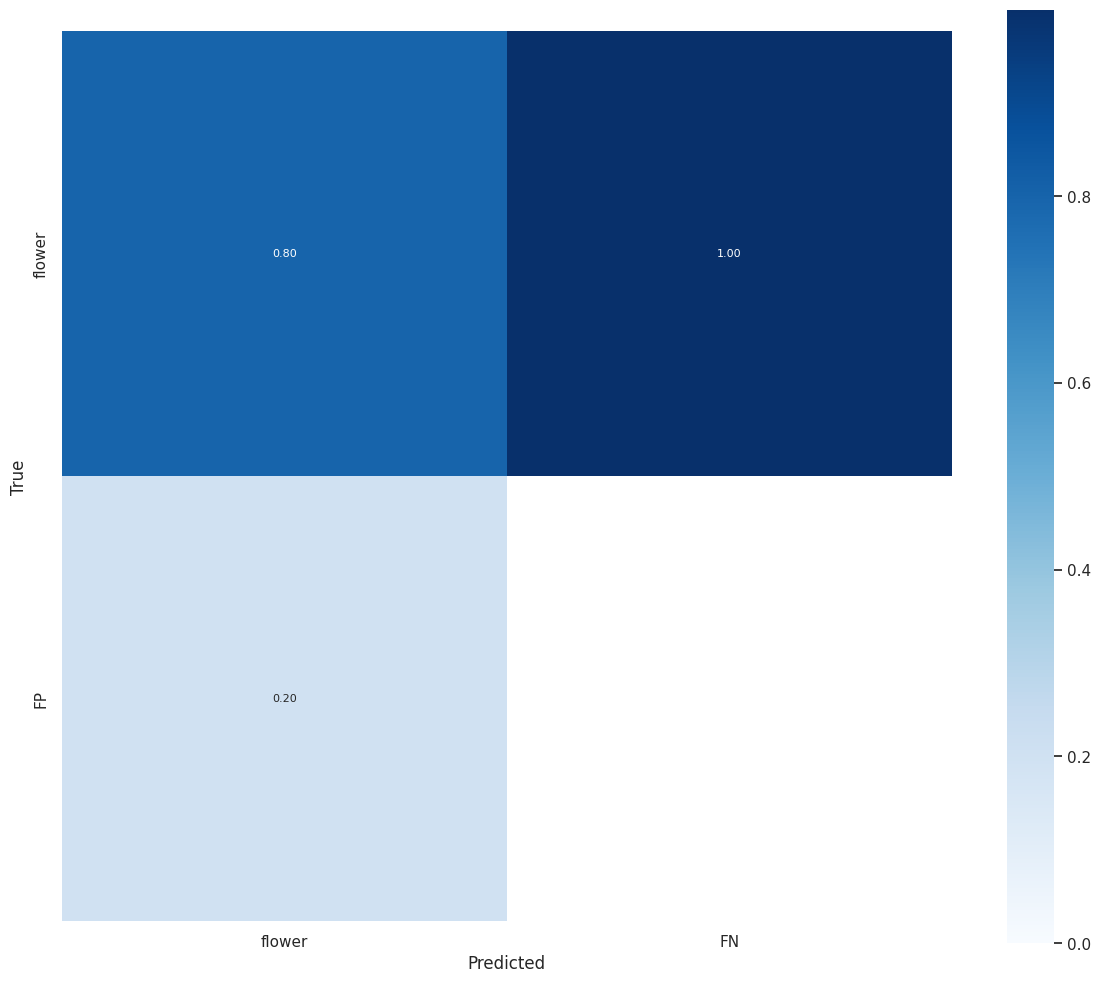

In [21]:
import os
HOME = os.getcwd()

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)

# 3. Exporting models

## 3.1. Path to store the models

In [22]:
data_model_export_path = "model_export"

## 3.2. Choose Runtime TRT or Onnx

### 3.2.1. Export for TensorRT Runtime

In [23]:
from super_gradients.conversion import ExportTargetBackend
best_model.export(f"{data_model_export_path}/yolo_nas_s_custom.onnx", #Change name of the model 
                confidence_threshold = 0.6,
                nms_threshold = 0.65,
                num_pre_nms_predictions = 1000,
                max_predictions_per_image = 10,
                engine=ExportTargetBackend.TENSORRT) # It works with TensorRT

[2024-06-26 11:40:24] INFO - nms.py - Created NMS plugin 'EfficientNMS_TRT' with attributes: {'plugin_version': '1', 'background_class': -1, 'max_output_boxes': 10, 'score_threshold': 0.6, 'iou_threshold': 0.65, 'score_activation': False, 'box_coding': 0}


Model exported successfully to model_export/yolo_nas_s_customv2.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=10
    nms_threshold=0.65
    confidence_threshold=0.6
    output_predictions_format=batch

Exported model is in ONNX format and can be used with TensorRT
To run inference with TensorRT, please see TensorRT deployment documentation
You can benchmark the model using the following code snippet:

    trtexec --onnx=model_export/yolo_nas_s_customv2.onnx --fp16 --avgRuns=100 --duration=15

Exported model has predictions in batch fo

### 3.2.1. Export for ONNX runtime

In [20]:
from super_gradients.conversion import ExportTargetBackend
best_model.export(f"{data_model_export_path}/yolo_nas_s_custom.onnx", #Change name of the model
                confidence_threshold = 0.5,
                nms_threshold = 0.65,
                num_pre_nms_predictions = 1000,
                max_predictions_per_image = 10,
                engine=ExportTargetBackend.ONNXRUNTIME)

Model exported successfully to model_export/yolo_nas_s_custom.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=10
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("model_export/yolo_nas_s_custom.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvi

Note:
The general workflow during and after training is the following:
1. Training in PC:
    - It is highly recommended to train in PC with decent GPU capabilities > GTX 1060.
    - Given the quantity of packages and their sizes in this Anaconda environment is not recommended training in the final PC as Jetson AGX Orin because memory restrictions.
2. Conversion of ONNX to TensorRT
    - In order to increase the speed of processing of the model.
    - Do this conversion in the PC that would be executed. (E.g. Jetson AGX Orin, PC, etc)
3. Run finally in the PC or SBC: 
    - It could be run as simple python code or ROS2 node.